In [2]:
# Cell 1: Imports and Setup
import os
os.chdir('../')  # Moving up one directory to the root
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from main import SentimentAnalyzer
from config.model_config import Config
from models.sentiment_model import EnhancedDistilBertForSentiment, ModelTrainer
from models.modelPersistence import ModelPersistence
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

2024-12-16 15:40:19.537865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Transformers package location: /opt/anaconda3/lib/python3.12/site-packages/transformers/__init__.py


In [3]:
# Cell 2: Initialize Analyzer and Process Data
analyzer = SentimentAnalyzer()
processed_data = analyzer.process_data()

# Print dataset statistics from processed_data
print("\nDataset Statistics:")
for split in ['train', 'val', 'test']:
    df = processed_data['dataframes'][split]
    print(f"\n{split.capitalize()} Set:")
    print(f"Total samples: {len(df)}")
    print(f"Sarcastic samples: {df['is_sarcastic'].sum()} ({df['is_sarcastic'].mean()*100:.1f}%)")
    sentiment_dist = df['sentiment'].value_counts()
    for sentiment in sorted(sentiment_dist.index):
        print(f"Sentiment {sentiment}: {sentiment_dist[sentiment]} samples")

Creating dataset with 1000 samples per class

Raw Dataset

   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...

Sentiment added

   label                                               text  \
0      4  dr. goldberg offers everything i look for in a...   
1      1  Unfortunately, the frustration of being Dr. Go...   
2      3  Been going to Dr. Goldberg for over 10 years. ...   
3      3  Got a letter in the mail last week that said D...   
4      0  I don't know what Dr. Goldberg was like before...   

                                      processed_text  is_sarcastic  sentiment  
0  dr. goldberg offers everything i look for in a...         False          2  
1  unfortunately, the fr

In [4]:
# Cell 3: Initialize Model
analyzer.initialize_model()

# Print model configuration
print("\nModel Configuration:")
print(f"BERT Model: {Config.BERT_MODEL}")
print(f"Learning Rate: {Config.LEARNING_RATE}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Max Length: {Config.MAX_LENGTH}")
print(f"LSTM Units: {Config.LSTM_UNITS}")
print(f"Feature Dimension: {Config.FEATURE_DIM}")
print(f"Fusion Layers: {Config.FUSION_LAYERS}")
print(f"Dropout Rates: {Config.DROPOUT_RATES}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



Model Configuration:
BERT Model: distilbert-base-uncased
Learning Rate: 1e-05
Batch Size: 32
Max Length: 128
LSTM Units: 96
Feature Dimension: 48
Fusion Layers: [192, 96]
Dropout Rates: [0.5, 0.6]


In [5]:
# Cell 4: Model Architecture Verification
analyzer.verify_model_architecture()


Model Architecture Summary:
Model: "enhanced_distil_bert_for_sentiment"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model (TFDi  multiple                  66362880  
 stilBertModel)                                                  
                                                                 
 bidirectional (Bidirection  multiple                  664320    
 al)                                                             
                                                                 
 layer_normalization (Layer  multiple                  384       
 Normalization)                                                  
                                                                 
 layer_normalization_1 (Lay  multiple                  96        
 erNormalization)                                                
                                                                 
 la

In [6]:
# Cell 5: Training
history = analyzer.trainer.train(analyzer.train_dataset, analyzer.val_dataset)

Epoch 1/10
94/94 [==============================] - 644s 6s/step - loss: 1.3571 - accuracy: 0.3373 - val_loss: 1.0409 - val_accuracy: 0.5255 - lr: 9.9524e-06
Epoch 2/10
94/94 [==============================] - 627s 7s/step - loss: 1.1212 - accuracy: 0.4197 - val_loss: 0.8708 - val_accuracy: 0.6452 - lr: 9.9045e-06
Epoch 3/10
94/94 [==============================] - 613s 7s/step - loss: 0.9775 - accuracy: 0.5200 - val_loss: 0.7908 - val_accuracy: 0.6608 - lr: 9.8569e-06
Epoch 4/10
94/94 [==============================] - 610s 6s/step - loss: 0.8643 - accuracy: 0.6030 - val_loss: 0.7699 - val_accuracy: 0.6563 - lr: 9.8095e-06
Epoch 5/10
94/94 [==============================] - 597s 6s/step - loss: 0.7505 - accuracy: 0.6907 - val_loss: 0.7671 - val_accuracy: 0.6785 - lr: 9.7623e-06
Epoch 6/10
94/94 [==============================] - 584s 6s/step - loss: 0.6554 - accuracy: 0.7327 - val_loss: 0.7969 - val_accuracy: 0.6741 - lr: 9.7153e-06


In [16]:
# First, import required libraries at the top of your notebook
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(analyzer, batch_size=32):
    """Evaluate model on test set"""
    print(f"\nEvaluating model...")
    
    # Extract test data from processed_data
    test_df = analyzer.processed_data['dataframes']['test']
    test_texts = test_df['processed_text'].to_numpy()
    test_labels = {
        'sentiment': test_df['sentiment'].values,
        'is_sarcastic': test_df['is_sarcastic'].values
    }
    
    # Prepare features
    print("\nPreparing input features...")
    features = analyzer.trainer.prepare_dataset(test_texts)
    
    # Generate predictions
    print("\nGenerating predictions...")
    predictions = []
    total_batches = (len(test_texts) + batch_size - 1) // batch_size
    
    for i in range(0, len(test_texts), batch_size):
        batch_features = {
            'input_ids': features['input_ids'][i:i+batch_size],
            'attention_mask': features['attention_mask'][i:i+batch_size]
        }
        batch_pred = analyzer.model(batch_features, training=False)
        predictions.append(batch_pred)
        print(f"Progress: {(i+batch_size)//batch_size}/{total_batches} batches")
        
    predictions = tf.concat(predictions, axis=0)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()
    
    # Calculate metrics
    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    metrics = {
        'accuracy': float(np.mean(predicted_labels == test_labels['sentiment'])),
        'confusion_matrix': confusion_matrix(test_labels['sentiment'], predicted_labels),
        'classification_report': classification_report(
            test_labels['sentiment'],
            predicted_labels,
            target_names=[label_map[i] for i in range(3)],
            output_dict=True
        )
    }
    
    # Add sarcasm-specific metrics
    sarcastic_mask = test_labels['is_sarcastic']
    metrics['sarcastic_accuracy'] = float(np.mean(
        predicted_labels[sarcastic_mask] == test_labels['sentiment'][sarcastic_mask]
    ))
    
    metrics['non_sarcastic_accuracy'] = float(np.mean(
        predicted_labels[~sarcastic_mask] == test_labels['sentiment'][~sarcastic_mask]
    ))
    
    return metrics, predictions

def plot_training_history(history):
    """Plot training metrics history"""
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot learning rate if available
    if 'lr' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(metrics):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sns.heatmap(
        metrics['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[label_map[i] for i in range(3)],
        yticklabels=[label_map[i] for i in range(3)]
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_performance_metrics(metrics):
    """Plot detailed performance metrics"""
    plt.figure(figsize=(15, 10))
    
    # Performance by category
    plt.subplot(2, 1, 1)
    categories = ['Negative', 'Neutral', 'Positive']
    report = metrics['classification_report']
    
    metrics_data = {
        'Precision': [report[cat]['precision'] for cat in categories],
        'Recall': [report[cat]['recall'] for cat in categories],
        'F1-Score': [report[cat]['f1-score'] for cat in categories]
    }
    
    x = np.arange(len(categories))
    width = 0.25
    
    plt.bar(x - width, metrics_data['Precision'], width, label='Precision')
    plt.bar(x, metrics_data['Recall'], width, label='Recall')
    plt.bar(x + width, metrics_data['F1-Score'], width, label='F1-Score')
    
    plt.xlabel('Sentiment Category')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Category')
    plt.xticks(x, categories)
    plt.legend()
    
    # Sarcasm impact
    plt.subplot(2, 1, 2)
    sarcasm_metrics = [
        metrics['non_sarcastic_accuracy'],
        metrics['sarcastic_accuracy'],
        metrics['accuracy']
    ]
    plt.bar(['Non-Sarcastic', 'Sarcastic', 'Overall'],
            sarcasm_metrics,
            color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Accuracy by Sarcasm Type')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

def print_detailed_metrics(metrics):
    """Print detailed evaluation metrics"""
    print("\nDetailed Performance Metrics:")
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Sarcastic Text Accuracy: {metrics['sarcastic_accuracy']:.4f}")
    print(f"Non-sarcastic Text Accuracy: {metrics['non_sarcastic_accuracy']:.4f}")
    
    categories = ['Negative', 'Neutral', 'Positive']
    report = metrics['classification_report']
    
    for category in categories:
        print(f"\n{category} Metrics:")
        print(f"Precision: {report[category]['precision']:.4f}")
        print(f"Recall: {report[category]['recall']:.4f}")
        print(f"F1-score: {report[category]['f1-score']:.4f}")


Evaluating model...

Preparing input features...

Generating predictions...
Progress: 1/15 batches
Progress: 2/15 batches
Progress: 3/15 batches
Progress: 4/15 batches
Progress: 5/15 batches
Progress: 6/15 batches
Progress: 7/15 batches
Progress: 8/15 batches
Progress: 9/15 batches
Progress: 10/15 batches
Progress: 11/15 batches
Progress: 12/15 batches
Progress: 13/15 batches
Progress: 14/15 batches
Progress: 15/15 batches


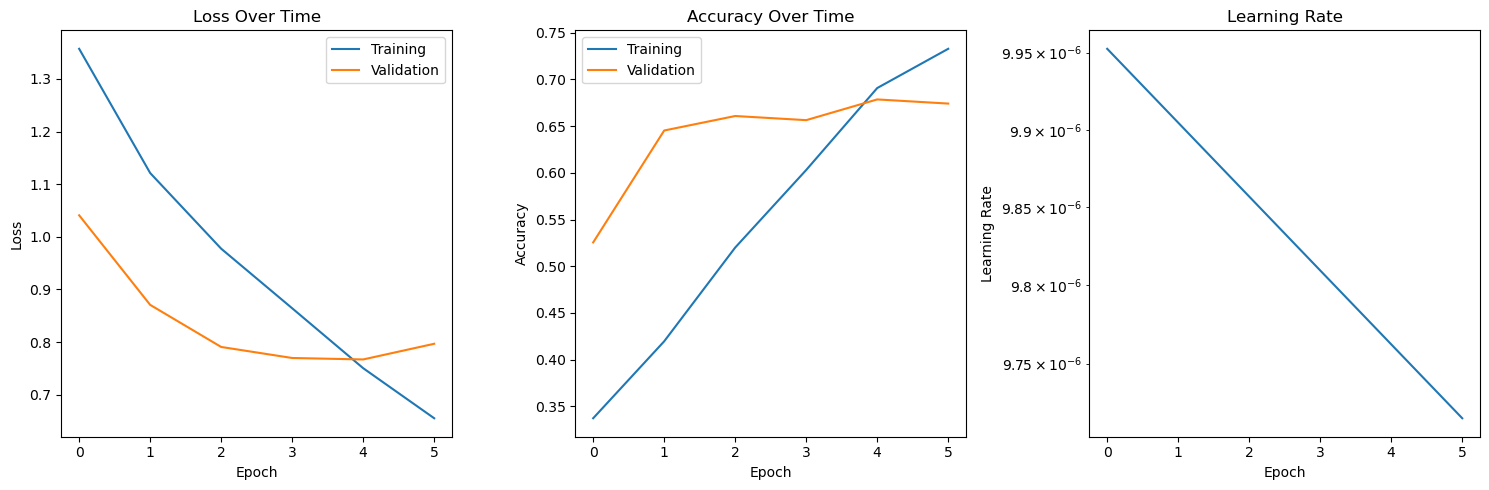

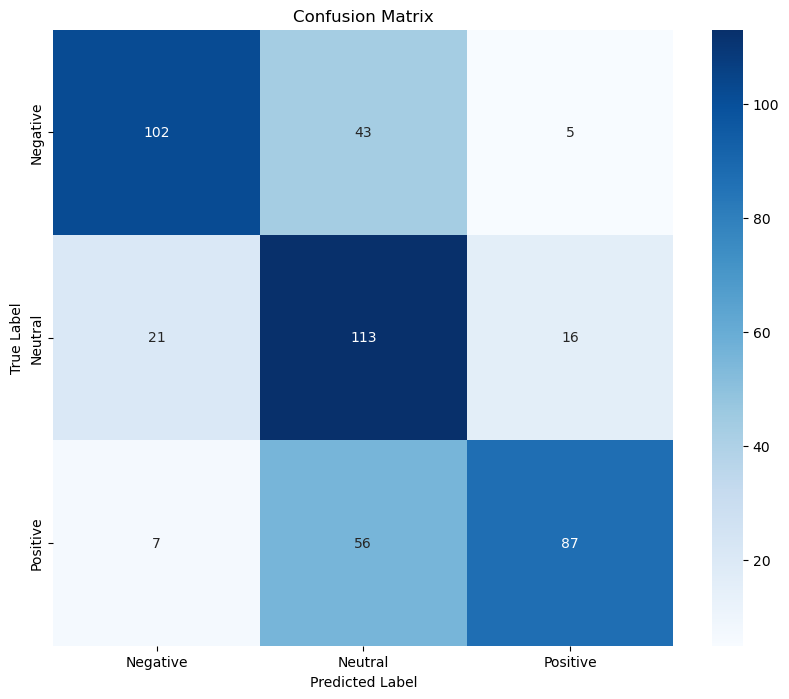

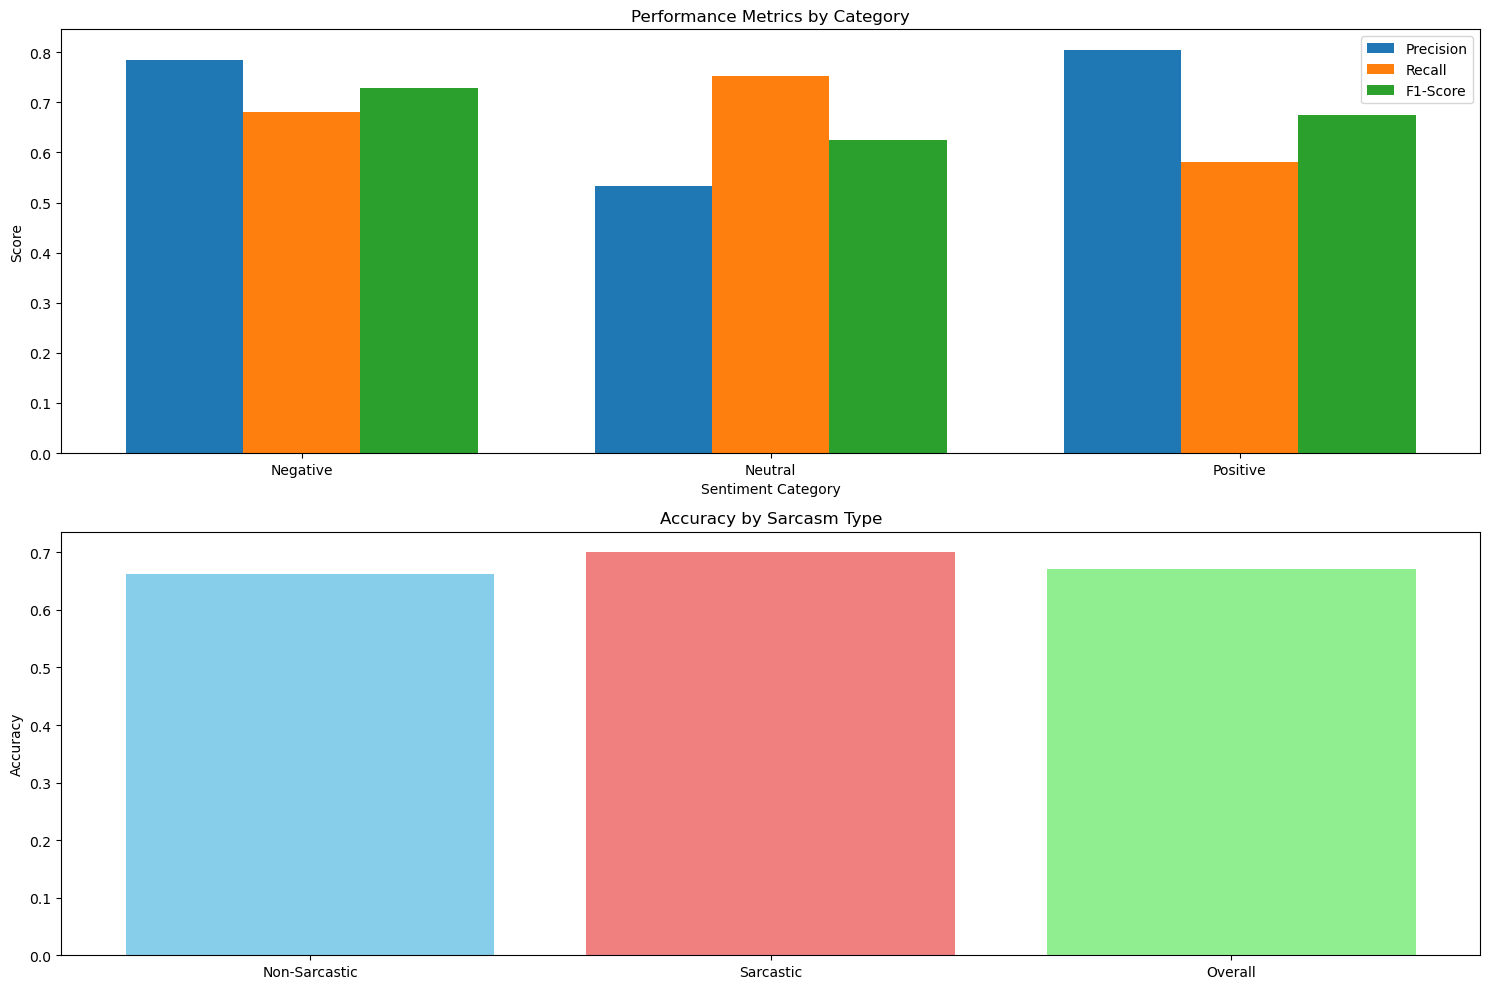


Detailed Performance Metrics:
Overall Accuracy: 0.6711
Sarcastic Text Accuracy: 0.7009
Non-sarcastic Text Accuracy: 0.6618

Negative Metrics:
Precision: 0.7846
Recall: 0.6800
F1-score: 0.7286

Neutral Metrics:
Precision: 0.5330
Recall: 0.7533
F1-score: 0.6243

Positive Metrics:
Precision: 0.8056
Recall: 0.5800
F1-score: 0.6744


In [18]:
# Evaluate model
metrics, predictions = evaluate_model(analyzer)

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(metrics)

# Plot performance metrics
plot_performance_metrics(metrics)

# Print detailed metrics
print_detailed_metrics(metrics)

In [20]:
# Cell 8: Save Model
def save_model(epoch, history, model, tokenizer, model_dir=None, version=None):
    """Save the trained model and associated artifacts"""
    if model_dir is None:
        model_dir = os.path.join(os.getcwd(), 'saved_models')
    
    if version is None:
        version = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    save_dir = os.path.join(model_dir, f"model_v{version}_epoch{epoch}")
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(save_dir, "full_model")
    tf.keras.models.save_model(model, model_path)
    
    # Save tokenizer
    tokenizer_path = os.path.join(save_dir, "tokenizer")
    tokenizer.save_pretrained(tokenizer_path)
    
    # Save config
    config = {
        'model_params': {
            'bert_model': Config.BERT_MODEL,
            'lstm_units': Config.LSTM_UNITS,
            'feature_dim': Config.FEATURE_DIM,
            'fusion_layers': Config.FUSION_LAYERS,
            'dropout_rates': Config.DROPOUT_RATES,
            'num_classes': Config.NUM_CLASSES
        },
        'training_params': {
            'max_length': Config.MAX_LENGTH,
            'batch_size': Config.BATCH_SIZE,
            'learning_rate': Config.LEARNING_RATE,
            'num_epochs': Config.EPOCHS
        },
        'performance': {
            'final_train_accuracy': history.history['accuracy'][-1],
            'final_val_accuracy': history.history['val_accuracy'][-1],
            'best_val_accuracy': max(history.history['val_accuracy'])
        }
    }
    
    config_path = os.path.join(save_dir, "config.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"Model saved to: {save_dir}")
    return save_dir



In [22]:
# Save the trained model
save_path = save_model(
    epoch=len(history.history['loss']),
    history=history,
    model=analyzer.model,
    tokenizer=analyzer.tokenizer,
    version='2.0.0'
)
print(f"Model artifacts saved to: {save_path}")

INFO:tensorflow:Assets written to: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models/model_v2.0.0_epoch6/full_model/assets


INFO:tensorflow:Assets written to: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models/model_v2.0.0_epoch6/full_model/assets


Model saved to: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models/model_v2.0.0_epoch6
Model artifacts saved to: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models/model_v2.0.0_epoch6
